In [1]:
import numpy as np

from os import listdir
from os.path import join

import cv2

from sklearn.model_selection import train_test_split

import albumentations as A

import matplotlib.pyplot as plt

In [2]:
# Loading images into python

data_path = "./dataset"

data = []
gt_labels = []
label_class = 0

for data_class in listdir(data_path):
    if (".npy" not in data_class) and (".txt" not in data_class):
        for img in listdir(join(data_path, data_class)):
            if "DS_Store" not in img:
                temp = cv2.imread(join(data_path, data_class, img), 0) #,0 in case grayscale
                # b_temp = temp[:,:,1]
                # r_temp = temp[:,:,2]
                # temp[:,:,0] = r_temp
                # temp[:,:,2] = b_temp
                data.append(temp) # RGB stored in BGR
                gt_labels.append(label_class)
        label_class += 1

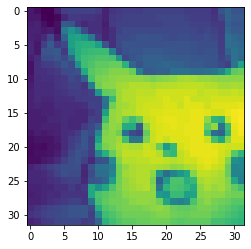

In [3]:
plt.imshow(data[80])

In [4]:
print(f"Data shape: {np.stack(data).shape}, label shape: {len(gt_labels)}")

Data shape: (117, 32, 32), label shape: 117


In [5]:
# Split them in train and test
x_train, x_test, y_train, y_test = train_test_split(data, gt_labels, test_size=0.2)

In [6]:
print(f"Shapes train: {len(x_train)}, test: {len(x_test)}, label x: {len(y_train)}, label y: {len(y_test)}")

Shapes train: 93, test: 24, label x: 93, label y: 24


In [7]:
# Again some data augmentation: changing exposure with gamma transform
gamma = [0.1, 0.4, 2.5, 5]

for i in range(len(x_train)):
    # Implementing Gamma correction to generate new images to balance the dataset
    for g in gamma:
        x_train.append(np.power(x_train[i]/255, g)*255)
        y_train.append( y_train[i])

In [8]:
x_train = np.stack(x_train)
y_train = np.stack(y_train)

x_test = np.stack(x_test)
y_test = np.stack(y_test)

In [9]:
print(f"Shapes train: {x_train.shape}, test: {x_test.shape}, label x: {y_train.shape}, label y: {y_test.shape}")

Shapes train: (465, 32, 32), test: (24, 32, 32), label x: (465,), label y: (24,)


In [10]:
# Saving output
np.save(join(data_path, 'x_train_memes.npy'), x_train.astype(np.uint8))

# x_save = (((x_test/255.)-0.5)*256.).round().astype(np.int64)#.clamp(min=-128, max=127)
# x_save = np.clip(x_save, -128, 127)
np.save(join(data_path, 'x_test_memes.npy'), x_test.astype(np.uint8))

np.savetxt(join(data_path, 'train_labels_memes.txt'), y_train.astype(np.int8), fmt='%d', delimiter=',')
np.savetxt(join(data_path, 'test_labels_memes.txt'), y_test.astype(np.int8), fmt='%d', delimiter=',')

In [11]:
# Generating model

img_to_sample = x_test[4]
print(y_test[4])

x_save = (((img_to_sample/255.)-0.5)*256.).round().astype(np.int64)#.clamp(min=-128, max=127)
x_save = np.clip(x_save, -128, 127)

# plt.imshow(np.reshape(x_save, (30, 30)))
# plt.show()
np.save(join(data_path, 'sample_celeba_rgb.npy'), np.reshape(x_save, (1, 32, 32)))

1


# Keras data augmentation

In [12]:
transform = A.Compose([
    A.OpticalDistortion(),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=30),
    A.GaussNoise(),
    A.Affine(translate_percent=0.1),
    A.Affine(shear=10),
    A.Affine(scale=0.9),
    A.GaussianBlur(blur_limit=(3, 3)),
])

In [13]:
x_augmented = x_train
y_augmented = y_train
for _ in range(3):
    for img, lbl in zip(x_train, y_train):
        img_temp = transform(image=img.astype(np.uint8))['image']
        x_augmented = np.append(x_augmented, np.expand_dims(img_temp, axis=0), axis = 0)
        y_augmented = np.append(y_augmented, lbl)

In [14]:
print(x_augmented.shape)

(1860, 32, 32)


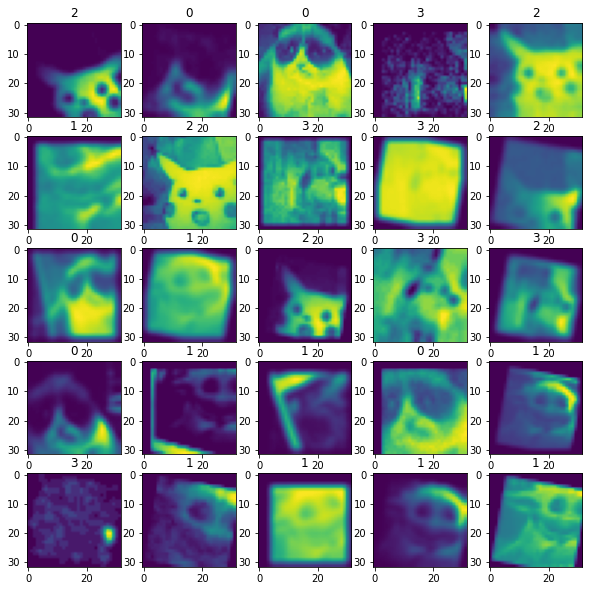

In [15]:
fig, ax = plt.subplots(5, 5, figsize = (10, 10))


for i in range(5):
    for j in range(5):
        index = np.random.randint(x_augmented.shape[0])
        ax[i, j].imshow(x_augmented[index])
        ax[i, j].set_title(str(y_augmented[index]))

In [16]:
print(f"0: {y_augmented[y_augmented == 0].shape[0]/y_augmented.shape[0]}, 1: {y_augmented[y_augmented == 1].shape[0]/y_augmented.shape[0]}, 2: {y_augmented[y_augmented == 2].shape[0]/y_augmented.shape[0]}, 3: {y_augmented[y_augmented == 3].shape[0]/y_augmented.shape[0]}")

0: 0.26881720430107525, 1: 0.21505376344086022, 2: 0.23655913978494625, 3: 0.27956989247311825


In [17]:
# Saving output
np.save(join(data_path, 'x_train_augmented_memes.npy'), x_augmented.astype(np.uint8))

np.savetxt(join(data_path, 'train_labels_augmented_memes.txt'), y_augmented.astype(np.int8), fmt='%d', delimiter=',')